In [1]:
import numpy as np
import random as r
import pandas as pd
import math
from neupy import algorithms
from neupy.layers import *

import matplotlib.pyplot as plt

# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# split the large dataset into train and test
from sklearn.model_selection import train_test_split
# Import the Logistic Regression model from scikit and matplot
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import mean_squared_error, r2_score

from sklearn import linear_model

from tensorflow.keras import datasets, layers, models

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#creates an empty dataframe
# (nbr of input columns (x1,...xn), nbr of output columns(y1,....yn))
def create_df_col_names(cols_in,cols_out):
    col_names=[]
    x='x'
    y='y'
    #input columns
    for i in range(1,cols_in+1):
       x='x'
       x+=str(i)
       col_names.append(x)
       
   #output columns
    for i in range(1,cols_out+1):
       y='y'
       y+=str(i)
       col_names.append(y)
    return col_names

In [3]:
col_names=[]
nbr_inputs=2
nbr_outputs=1
n_rows=5000
col_names=create_df_col_names(nbr_inputs,nbr_outputs)
print(col_names)

['x1', 'x2', 'y1']


In [4]:
df_obj = pd.DataFrame(columns=col_names)

In [5]:
df_obj.dtypes

x1    object
x2    object
y1    object
dtype: object

In [6]:
def generate_random_inputs():
    "Apply the given distribution to each row"
# For random samples from N(\mu, \sigma^2), use:
# default: (mu, sd)=(0,1)
#   sigma * np.random.randn(...) + mu 
    return ( 2.5 * np.random.randn(n_rows,nbr_inputs) + 3 )


table_in=generate_random_inputs()
#type(table_in)
#print(table_in)

In [7]:
#filling the dataframe
i=0
for x in col_names:
    if i<nbr_inputs:
        df_obj[x]=table_in[:,i]
    i+=1
for y in col_names[nbr_inputs:]: 
    df_obj[y] = df_obj[y].fillna(0.0)
df_obj['y1'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: y1, dtype: float64

In [8]:
df_obj[col_names[nbr_inputs]]
#df_obj[col_names[nbr_inputs]]=0.2206365 * df_obj[col_names[0]] *(1-1.35*math.exp(-0.18*( df_obj[col_names[1]] / df_obj[col_names[2]] )^1.39)) #L

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4995    0.0
4996    0.0
4997    0.0
4998    0.0
4999    0.0
Name: y1, Length: 5000, dtype: float64

In [9]:
def generate_outputs_with_func():
  '''Generates the necessary outputs based  on teh given formula
  '''
  df_obj[col_names[nbr_inputs]]=3* df_obj[col_names[0]] +5* df_obj[col_names[1]]**3
  
#generate outputs
generate_outputs_with_func()
df_obj.head()
#df_obj['y1'].max()

,x1,x2,y1
0,1.359179,-1.358905,-8.469386
1,2.078107,2.404094,75.708646
2,4.751854,3.595996,246.757964
3,-0.856865,4.033499,325.536752
4,1.401880,8.932142,3567.378260


,x1,x2
0,0.450410,0.253088
1,0.485397,0.464748
2,0.615515,0.531790
3,0.342566,0.556399
4,0.452488,0.831937


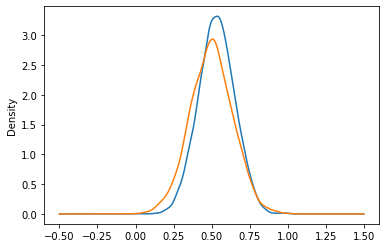

In [10]:
def lin_scale_df_inputs(x_bar_min,x_bar_max):
    '''
    Returns a scaled df within the given interval [x_bar_min,x_bar_max]
    Scaling the input columns using the linear scaling formula
    '''
    df_scaled=df_obj.copy()
    df_scaled.pop('y1').values
    for i in col_names[:nbr_inputs]:
        col_max=df_obj[i].max()
        col_min=df_obj[i].min()
        df_scaled[i]= x_bar_min + ((df_obj[i] - col_min) / (col_max - col_min)) * (x_bar_max - x_bar_min)
    return df_scaled

#linear scaling [-0.5,0.5]
df_lin_scaled_in=lin_scale_df_inputs(0,1)
# Density of inputs after linear scaling
df_lin_scaled_in['x1'].plot.density() # blue
df_lin_scaled_in['x2'].plot.density() # red
df_lin_scaled_in.head()

In [11]:
def lin_descale(df_scaled):
    '''
    Returns a scaled df within the given interval [x_bar_min,x_bar_max]
    Scaling the input columns using the linear scaling formula
    '''
    df_descaled=df_scaled.copy()
    for i in col_names[:nbr_inputs]:
        col_max=df_obj[i].max()
        col_min=df_obj[i].min()
        x_bar_max=df_scaled[i].max()
        x_bar_min=df_scaled[i].min()
        df_descaled[i]=((df_scaled[i]-x_bar_min)*(col_max - col_min)) / (x_bar_max - x_bar_min) + col_min
    return df_descaled

#linear scaling [-0.5,0.5]
#df_lin_descaled_x=lin_descale(df_lin_scaled_in)
# Density of inputs after linear scaling
#df_lin_descaled_x['x1'].plot.density() # blue
#df_lin_descaled_x['x2'].plot.density() # red
#df_lin_descaled_x.head()


,y1
0,6.902495
1,6.983727
2,7.130884
3,7.192002
4,8.427400


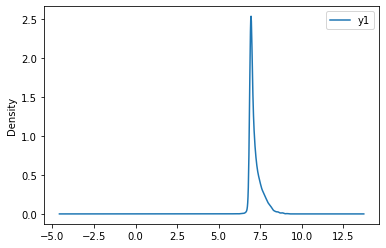

In [12]:
#normalizing every column
def log_scale_df_outputs():
    '''
    Returns the scaled df-output column(s) 
    Scaling the output columns using the log scaling formula
    '''
    df_norm=df_obj[col_names[nbr_inputs:]].copy()

    for i in col_names[nbr_inputs:]:
        col_min=df_obj[i].min()
        df_norm[i]=np.log(df_obj[i]-col_min+1)
    return df_norm

df_log_scaled_out=log_scale_df_outputs()
# density of outputs after log scaling
df_log_scaled_out.plot.density() # blue
df_log_scaled_out.head()

In [13]:
#normalizing every column
def log_descale(df_scaled):
    '''
    Returns the scaled df-output column(s) 
    Scaling the output columns using the log scaling formula
    '''
    #df_descaled=df_scaled[col_names[nbr_inputs:]].copy()
    df_descaled=df_scaled.copy()

    for i in col_names[nbr_inputs:]:
        col_min=df_obj[i].min()
        df_descaled=np.exp(df_scaled)+col_min-1
    return df_descaled


#df_log_descaled_y=log_descale(df_log_scaled_out)
# density of outputs after log scaling
#df_log_descaled_y.plot.density() # blue
#df_log_descaled_y['y1'].head()

In [14]:
df_obj.head()

,x1,x2,y1
0,1.359179,-1.358905,-8.469386
1,2.078107,2.404094,75.708646
2,4.751854,3.595996,246.757964
3,-0.856865,4.033499,325.536752
4,1.401880,8.932142,3567.378260


In [15]:
df_obj.describe(percentiles=[.25, .5, .75])

,x1,x2,y1
count,5000.000000,5000.000000,5000.000000
mean,3.038644,3.014241,429.456107
std,2.443513,2.497653,744.260387
min,-7.896115,-5.858413,-1002.223397
25%,1.396896,1.334763,22.906857
50%,3.043238,3.025295,149.278742
75%,4.673055,4.651855,515.533333
max,12.652471,11.920050,8482.378793


<AxesSubplot:ylabel='Density'>

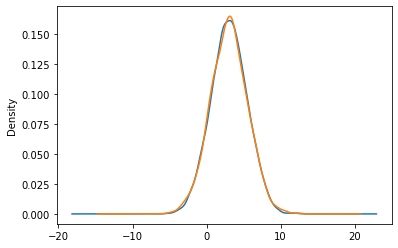

In [16]:
# Density of inputs
df_obj['x1'].plot.density() # blue
df_obj['x2'].plot.density() # red

744.260387032677

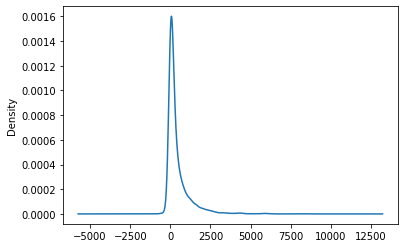

In [17]:
# Density of output(s)
df_obj['y1'].plot.density() # blue
df_obj['y1'].std()

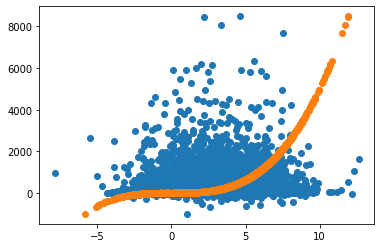

In [18]:
features_set=col_names[:nbr_inputs]
#blue
plt.scatter(df_obj[col_names[0]], df_obj[col_names[nbr_inputs]])
#red
plt.scatter(df_obj[col_names[1]], df_obj[col_names[nbr_inputs]])

#plt.scatter(x3, y)
#plt.scatter(x4, y)
plt.show()

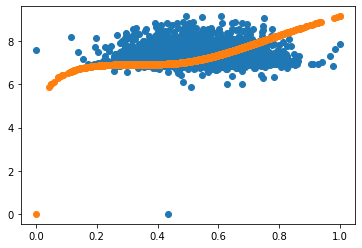

In [19]:
#ax = plt.subplot(xlim=(-0.5,1), ylim=(-5,5))
#blue
plt.scatter(df_lin_scaled_in[col_names[0]], df_log_scaled_out[col_names[nbr_inputs]])
#red
plt.scatter(df_lin_scaled_in[col_names[1]], df_log_scaled_out[col_names[nbr_inputs]])

In [36]:
X=df_lin_scaled_in[features_set].copy()
type(X)

pandas.core.frame.DataFrame

9.15753036902276


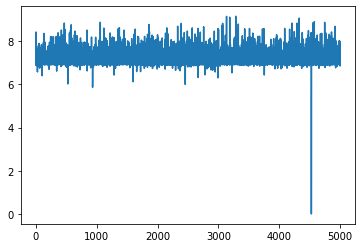

In [21]:
#plt.plot(df_norm['y1'])
plt.plot(df_log_scaled_out['y1'])
print(max(df_log_scaled_out['y1']))

In [37]:
#df_y=df.pop('y').values
df_y1=df_log_scaled_out['y1'].copy()

type(df_y1)

pandas.core.series.Series

In [29]:
# source: https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(df_obj)
# apply transform
normalized_minmax = scaler.transform(df_obj)
# inverse transform
#inverse = scaler.inverse_transform(normalized)
normalized_minmax



# x_norm_minmax=np.empty([n_rows,nbr_inputs],dtype=float)
# y_norm_minmax=np.empty([n_rows,nbr_outputs],dtype=float)
# for i in normalized_minmax:
#     #arr=np.empty((1,2),dtype=float)
#     #arr[0,0]=normalized_minmax[i,0]
#     #arr[0,1]=normalized_minmax[i,1]
#     arr=[]
#     arr=i[:nbr_inputs]
#     x_norm_minmax=np.append(x_norm_minmax , arr , axis=0) 
#     y_norm_minmax=np.append(y_norm_minmax, i[-1])

# x_norm_minmax.shape
# #y_norm_minmax

array([[0.45041024, 0.2530876 , 0.10477551],
       [0.48539698, 0.46474813, 0.11365074],
       [0.61551527, 0.53179001, 0.13168516],
       ...,
       [0.58975967, 0.70995115, 0.27010308],
       [0.66828542, 0.43496522, 0.11098725],
       [0.45684172, 0.20753166, 0.10076218]])

In [38]:
X1_norm=normalized_minmax.T[0]
X2_norm=normalized_minmax.T[1]
X['x1']=X1_norm
X['x2']=X2_norm
df_y1=normalized_minmax.T[2]

In [39]:
# split the large dataset into train and test
X_train, X_val, y_train, y_val = train_test_split(X, df_y1, test_size = 0.2, random_state=2)
# Look at the shape of the outputs

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(4000, 2)
(4000,)
(1000, 2)
(1000,)


In [50]:
max(y_train)

1.0

In [42]:
quasi_opt = models.Sequential([
        layers.Dense(10, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1)
    ])

quasi_opt.compile(optimizer='SGD', 
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

quasi_opt.fit(X_train, y_train, epochs=5)

Epoch 1/5
 51/125 [===========>..................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 

2021-10-29 13:35:40.671529: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at sparse_xent_op.cc:114 : Invalid argument: Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


InvalidArgumentError:  Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at var/folders/53/02cn8ff15sv08jy7_2fcpmw00000gn/T/ipykernel_48201/1127397154.py:11) ]] [Op:__inference_train_function_1538]

Function call stack:
train_function


In [46]:
#http://neupy.com/modules/generated/neupy.algorithms.QuasiNewton.html#neupy.algorithms.QuasiNewton
quasi_opt = algorithms.QuasiNewton(Input(2) >> Sigmoid(3) >> Sigmoid(1),update_function='bfgs')


In [47]:
quasi_opt.train(X_train, y_train, epochs=10)

In [58]:
print(y_val)

[0.13147262 0.31143817 0.11450979 0.21315078 0.1190522  0.10805172
 0.20998533 0.17321121 0.10558346 0.17765898 0.11947778 0.2176038
 0.10905926 0.25666172 0.11277035 0.14642431 0.2364564  0.10845732
 0.15359881 0.10802103 0.09876696 0.11916325 0.11153213 0.20318974
 0.14573242 0.35444858 0.33773288 0.10342006 0.10601089 0.1057061
 0.10469323 0.1725422  0.12698217 0.10860106 0.15293857 0.12423173
 0.20695677 0.10739808 0.104845   0.24485811 0.12252862 0.10811427
 0.10899514 0.17669463 0.10594298 0.11857    0.13701895 0.11261164
 0.18372834 0.12223749 0.11221089 0.11712315 0.31663765 0.10828862
 0.116784   0.10715554 0.1063592  0.22386418 0.12708786 0.15879315
 0.12205211 0.23511062 0.20954921 0.11820794 0.10715915 0.10608511
 0.1359495  0.11337571 0.0854275  0.10611022 0.13450709 0.11493648
 0.26652044 0.1130323  0.16050736 0.10652031 0.1055652  0.23372892
 0.10756636 0.20452767 0.10623891 0.10791565 0.10645134 0.10618512
 0.1635312  0.10707391 0.21203351 0.16205376 0.15920239 0.125410

In [49]:
clf_quasi_train= quasi_opt.fit(X_train, y_train)
clf_quasi_val = quasi_opt.fit(X_val, y_val)

In [51]:
y_pred=quasi_opt.predict(X_val)
#y_pred=quasi_opt.predict(df_lin_descaled_x)

In [54]:
#unique, counts = np.unique(y_pred, return_counts=True)
#print(np.asarray((unique, counts)))
min(y_pred)
max(y_pred)

array([0.87066041])

In [ ]:
#descale x
#df_lin_descaled_x=lin_descale(X_val)
#descale y
#df_log_descaled_y=log_descale(y_val)

In [ ]:
#y_pred_descaled=log_descale(y_pred)

In [133]:
#
# print("y_pred max:",max(y_pred_descaled),"y_pred min:",min(y_pred_descaled),"y_val max:",max(df_log_descaled_y))

In [136]:
#for (layer, varname),variable in quasi_opt.variables.items():
#    print(layer.name, varname, variable.shape)

quasi_opt.variables.get()

{'network_inputs': [layer:input-2/var:input],
 'network_output': algo:network/var:network-output,
 'step': algo:network/scalar:step,
 'epoch': algo:network/scalar:epoch,
 'prediction_func': sigmoid.0,
 'train_prediction_func': sigmoid.0,
 'error_func': mean,
 'validation_error_func': mean,
 'inv_hessian': algo:quasi-newton/matrix:inv-hessian,
 'prev_params': algo:quasi-newton/vector:prev-params,
 'prev_full_gradient': algo:quasi-newton/vector:prev-full-gradient}

In [56]:
quasi_opt.train_errors

[array(0.12660103),
 array(0.07728656),
 array(0.01064268),
 array(0.00760855),
 array(0.00658691),
 array(0.00649588),
 array(0.00649088),
 array(0.0064897),
 array(0.00648346),
 array(0.00647048),
 array(0.00643416),
 array(0.00634541),
 array(0.00612164),
 array(0.00556206),
 array(0.00498116),
 array(0.00487621),
 array(0.00481942),
 array(0.00474093),
 array(0.00472309),
 array(0.00471913),
 array(0.00471701),
 array(0.00470427),
 array(0.00467846),
 array(0.00460565),
 array(0.00442197),
 array(0.0038279),
 array(0.00242544),
 array(0.00228592),
 array(0.00219601),
 array(0.00217618),
 array(0.00217462),
 array(0.00217317),
 array(0.00216085),
 array(0.00213696),
 array(0.00205317),
 array(0.00195974),
 array(0.00193719),
 array(0.00190477),
 array(0.00189112),
 array(0.00188373),
 array(0.00186485),
 array(0.00182827),
 array(0.00179153),
 array(0.00171007),
 array(0.00163824),
 array(0.00154175),
 array(0.0013388),
 array(0.00109579),
 array(0.00082761),
 array(0.0006283),
 arr

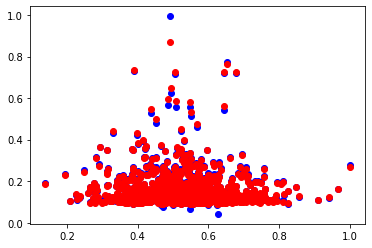

In [60]:
plt.scatter(X_val['x1'],y_val,color='blue')
plt.scatter(X_val['x1'],y_pred,color='red')
#plt.scatter(df_lin_descaled_x['x1'],y_pred_descaled,color='green')

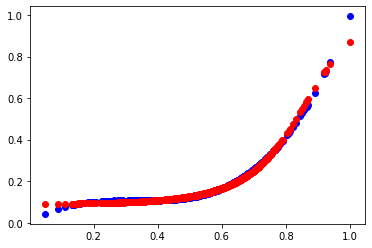

In [84]:
plt.scatter(X_val['x2'],y_val,color='blue')
plt.scatter(X_val['x2'],y_pred,color='red')
#plt.scatter(df_lin_descaled_x['x2'],y_pred_descaled,color='green')

In [85]:
quasi_opt.variables

{'network_inputs': [layer:input-2/var:input],
 'network_output': algo:network/var:network-output,
 'step': algo:network/scalar:step,
 'epoch': algo:network/scalar:epoch,
 'prediction_func': sigmoid.0,
 'train_prediction_func': sigmoid.0,
 'error_func': mean,
 'validation_error_func': mean,
 'inv_hessian': algo:quasi-newton/matrix:inv-hessian,
 'prev_params': algo:quasi-newton/vector:prev-params,
 'prev_full_gradient': algo:quasi-newton/vector:prev-full-gradient}

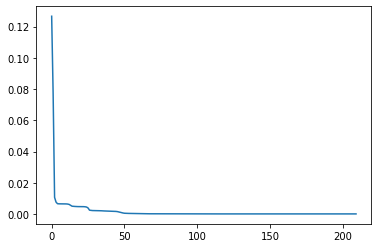

In [79]:
plt.plot(quasi_opt.errors)

In [145]:
#mean of the train errors
quasi_opt.error(y_val,y_pred).eval()

array(0.01421902)

In [106]:
df_pred=X_val.copy()
df_pred['y1']=y_pred.copy()

df_val=X_val.copy()
df_val['y1']=y_val.copy()

df_train=X_train.copy()
df_train['y1']=y_train.copy()

inverse_pred_t = scaler.inverse_transform(df_pred)
inverse_val_t = scaler.inverse_transform(df_val)
inverse_train_t = scaler.inverse_transform(df_train)


In [107]:
inverse_pred=inverse_pred_t.T
inverse_val=inverse_val_t.T
inverse_train=inverse_train_t.T

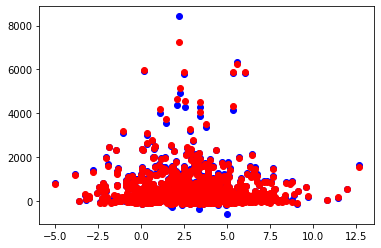

In [109]:
plt.scatter(inverse_val[0],inverse_val[2],color='blue')
plt.scatter(inverse_pred[0],inverse_pred[2],color='red')

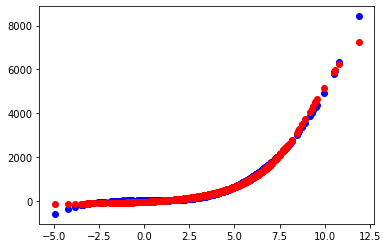

In [113]:
plt.scatter(inverse_val[1],inverse_val[2],color='blue')
plt.scatter(inverse_pred[1],inverse_pred[2],color='red')

In [126]:
quasi_opt.error(inverse_val[2], inverse_pred[2])

mean

In [131]:
quasi_opt.errors

[array(0.12660103),
 array(0.07728656),
 array(0.01064268),
 array(0.00760855),
 array(0.00658691),
 array(0.00649588),
 array(0.00649088),
 array(0.0064897),
 array(0.00648346),
 array(0.00647048),
 array(0.00643416),
 array(0.00634541),
 array(0.00612164),
 array(0.00556206),
 array(0.00498116),
 array(0.00487621),
 array(0.00481942),
 array(0.00474093),
 array(0.00472309),
 array(0.00471913),
 array(0.00471701),
 array(0.00470427),
 array(0.00467846),
 array(0.00460565),
 array(0.00442197),
 array(0.0038279),
 array(0.00242544),
 array(0.00228592),
 array(0.00219601),
 array(0.00217618),
 array(0.00217462),
 array(0.00217317),
 array(0.00216085),
 array(0.00213696),
 array(0.00205317),
 array(0.00195974),
 array(0.00193719),
 array(0.00190477),
 array(0.00189112),
 array(0.00188373),
 array(0.00186485),
 array(0.00182827),
 array(0.00179153),
 array(0.00171007),
 array(0.00163824),
 array(0.00154175),
 array(0.0013388),
 array(0.00109579),
 array(0.00082761),
 array(0.0006283),
 arr